# Test Data Generator for MCXcorStacking Module
First we have to define a set of functions.  These functions were derived from and older version of the deconvolution tutorial.  They are used to generate the simulation data that we pickle and store as a file.  That file is read by the functions in test_MCXcorStacking.py.  That approach is used instead of generating the data on the fly because we need to create data with noise to test some features of the algorithms in teh MCXcorStacking module.  

In [1]:
import numpy as np
from scipy import signal
from numpy.random import randn

from mspasspy.ccore.seismic import (Seismogram,
                                    TimeSeries,
                                    TimeSeriesEnsemble,
                                    TimeReferenceType,
                                    )

from mspasspy.algorithms.basic import ExtractComponent
from mspasspy.algorithms.window import scale


def make_impulse_vector(lag,imp,n=500):
    """
    Computes a (sparse) vector of impulse functions at a specified set of
    lags.   Used for generating fake data for a number of contexts.
    
    :param lag: is a list of lag values (int in samples) parallel with imp
    :param imp: is a list of values (amplitudes) for each lag.  Algorithm is
       simply to insert imp value at specified lag.  
    :param n: length of output vector returned.
    :return: numpy vector of doubles of length n.  zero where lag,imp not defined.
    """
    if(len(lag)!=len(imp)):
        raise RuntimeError("make_impulse_vector:  lag and imp vectors must be equal length")
    d=np.ndarray(n)
    for i in range(n):
        d[i]=0.0
    for i in range(len(lag)):
        if((lag[i]<0) | (lag[i]>=n)):
            raise RuntimeError("make_impulse_vector:  lag out of range");
        d[lag[i]]=imp[i]
    return d

def make_wavelet_noise_data(nscale=0.1,ns=2048,padlength=512,
        dt=0.05,npoles=3,corners=[0.08,0.8]):
    wn=TimeSeries(ns)
    wn.t0=0.0
    wn.dt=dt
    wn.tref=TimeReferenceType.Relative
    wn.live=True
    nd=ns+2*padlength
    y=nscale*randn(nd)
    sos=signal.butter(npoles,corners,btype='bandpass',output='sos',fs=1.0/dt)
    y=signal.sosfilt(sos,y)
    for i in range(ns):
        wn.data[i]=y[i+padlength]
    return(wn)
def make_simulation_wavelet(n=100,dt=0.05,t0=-1.0,
                            imp=(20.0,-15.0,4.0,-1.0),
                            lag=(20,24,35,45),
                            npoles=3,
                            corners=[2.0,6.0]):
    dvec=make_impulse_vector(lag,imp,n)
    fsampling=int(1.0/dt)
    sos=signal.butter(npoles,corners,btype='bandpass',output='sos',fs=fsampling)
    f=signal.sosfilt(sos,dvec)
    wavelet=TimeSeries(n)
    wavelet.set_t0(t0)
    wavelet.set_dt(dt)
    # This isn't necessary at the moment because relative is the default
    #wavelet.set_tref(TimeReferenceType.Relative)
    wavelet.set_npts(n)
    wavelet.set_live()
    for i in range(n):
        wavelet.data[i]=f[i]
    return wavelet
def make_impulse_data(n=1024,dt=0.05,t0=-5.0):
    # Compute lag for spike at time=0
    lag0=int(-t0/dt)
    z=make_impulse_vector([lag0],[150.0],n)
    rf_lags=(lag0,lag0+50,lag0+60,lag0+150,lag0+180)
    amps1=(10.0,20.0,-60.0,-3.0,2.0)
    amps2=(-15.0,30.0,10.0,-20.0,15.0)
    ns=make_impulse_vector(rf_lags,amps1,n)
    ew=make_impulse_vector(rf_lags,amps2,n)
    d=Seismogram(n)
    d.set_t0(t0)
    d.set_dt(dt)
    d.set_live()
    d.tref=TimeReferenceType.Relative
    for i in range(n):
        d.data[0,i]=ew[i]
        d.data[1,i]=ns[i]
        d.data[2,i]=z[i]
    return d

def convolve_wavelet(d,w):
    """
    Convolves wavelet w with 3C data stored in Seismogram object d 
    to create simulated data d*w.   Returns a copy of d with the data 
    matrix replaced by the convolved data.
    """
    dsim=Seismogram(d)
    # We use scipy convolution routine which requires we copy the 
    # data out of the d.data container one channel at a time.
    wavelet=[]
    n=w.npts
    for i in range(n):
        wavelet.append(w.data[i])
    for k in range(3):
        work=[]
        n=d.npts
        for i in range(n):
            work.append(d.data[k,i])
        # Warning important to put work first and wavelet second in this call
        # or timing will be foobarred
        work=signal.convolve(work,wavelet)
        for i in range(n):
            dsim.data[k,i]=work[i]
    # timing correction needed to preserve timing
    # A version of this in decon simulation has this wrong
    dsim.t0 += w.t0
    return dsim
def addnoise(d,nscale=1.0,padlength=1024,npoles=3,corners=[0.1,1.0]):
    """
    Helper function to add noise to Seismogram d.  The approach is a 
    little weird in that we shift the data to the right by padlength 
    adding filtered random data to the front of the signal.   
    The padding is compensated by changes to t0 to preserve relative time 
    0.0.  The purpose of this is to allow adding colored noise to 
    a simulated 3C seismogram. 
    
    :param d: TimeSeries data to which noise is to be added and padded
    :param nscale:  noise scale for gaussian normal noise
    :param padlength:   data padded on front by this many sample of noise
    :param npoles: number of poles for butterworth filter 
    :param corners:  2 component array with corner frequencies for butterworth bandpass.
    """
    nd=d.npts
    n=nd+padlength
    result=TimeSeries(d)
    result.set_npts(n)
    newt0=d.t0-d.dt*padlength
    result.set_t0(newt0)
    # at the time this code was written we had a hole in the ccore 
    # api wherein operator+ and operator+= were not defined. Hence in this 
    # loop we stack the noise and signal inline.
    dnoise=nscale*randn(n)
    sos=signal.butter(npoles,corners,btype='bandpass',output='sos',fs=20.0)
    nfilt=signal.sosfilt(sos,dnoise)
    for i in range(n):
        result.data[i]=nfilt[i]
    for i in range(nd):
        t=d.time(i)
        ii=result.sample_number(t)
        # We don't test range here because we know we won't 
        # go outside bounds because of the logic of this function
        result.data[ii]+=d.data[i]
    return result
def make_test_data(snr=100.0):
    """
    Uses functions above, which were taken from the deconvolution tutorial, 
    to create a test data set for the MCXcorStacking module.   
    Returns a tuple with 3 components:
        1.  noise free wavelet estimate stored in a TimeSeries
        2.  TimeSeriesEnsemble of data with time shifts applied
        3.  vector of time shifts applied in seconds.   Note these 
            are constants original derived as random normal values.  
    """
    M = 20
    w = make_simulation_wavelet()
    d = make_impulse_data()
    d = convolve_wavelet(d, w)
    amplevel=0.5
    d = scale(d,method='peak',level=amplevel)

    d=ExtractComponent(d,2)
    # originally created as on instance of this
    # lag_in_sec = np.random.normal(scale=0.2,size=M)
    lag_in_sec = np.array([ 0.11377978,  0.14157338, -0.19732775, -0.10456551, -0.13559048,
           -0.17318283, -0.01108572, -0.28340258,  0.02973805, -0.05159073,
           -0.46799437,  0.04016743,  0.12821589,  0.17210118,  0.28651398,
           -0.00429737, -0.2394207 , -0.05986124, -0.00274017, -0.1206297 ])
    noise_level = amplevel/snr
    e = TimeSeriesEnsemble(M)
    d0 = TimeSeries(d)
    for i in range(20):
        d = TimeSeries(d0)
        d.t0 += lag_in_sec[i]
        d = addnoise(d,nscale=noise_level)
        d.force_t0_shift(1000.0)
        d.rtoa()
        # these are debris left from going through Seismogram 
        # also starttime metadata is not currently handled correctly by rtoa so 
        # we reset it
        d["starttime"]=d.t0
        for k in ["channel_hang","channel_vang"]:
            d.erase(k)
        e.member.append(d)
    e.set_live()
    # set these for assert tests
    for i in range(M):
        e.member[i]['lag_in_sec'] = lag_in_sec[i]
    return [w,e,lag_in_sec]

Run the top-level function from above and plot the results to verify it looks right.  Will set snr to 2.0 so the noise will be visible in the graphic.

In [2]:
from mspasspy.graphics import SeismicPlotter
w,ensemble,lags = make_test_data(snr=2.0)
plotter=SeismicPlotter()
plotter.change_style('wtva')

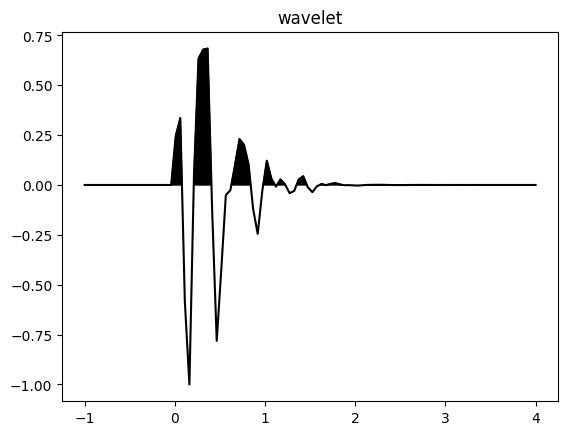

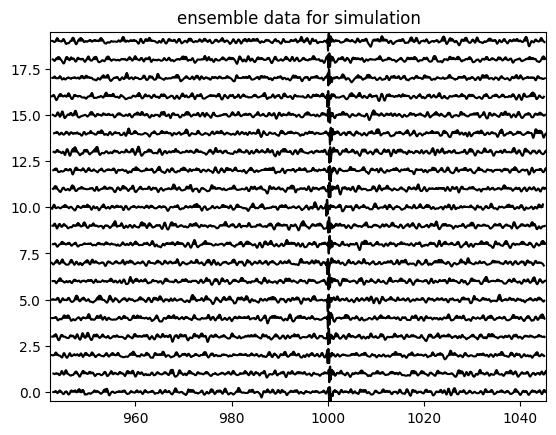

In [3]:
import matplotlib.pyplot as plt
wscaled=scale(w,method='peak',level=1.0)
plotter.plot(wscaled)
plt.title('wavelet')
plt.show()
plotter.plot(ensemble)
plt.title('ensemble data for simulation')
plt.show()  

Now that we know this is working we rerun the function with snr=100 and save all the output of the make_test_data function to a file with pickle.

In [4]:
import pickle

w,ensemble,lags = make_test_data(snr=100.0)
fname="./MCXcorStacking.testdata"
fd = open(fname,'wb')
pickle.dump(w,fd)
pickle.dump(ensemble,fd)
pickle.dump(lags,fd)
fd.close()

To avoid future confusion, note snr was changed here.  This is a plot of what was actually saved.   At high snr the background noise is below the dynamic range of the plot. 

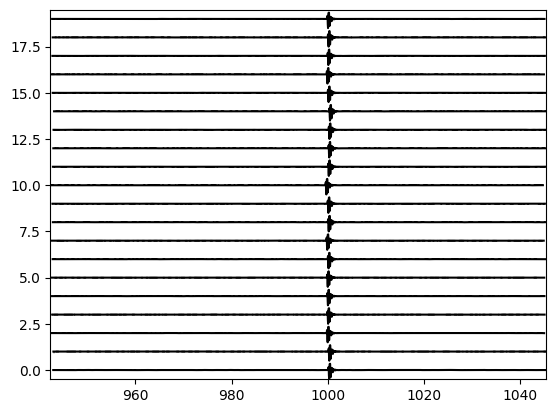

In [5]:
plotter.plot(ensemble)
plt.show()

Now verify that worked correctly and the content of the pickled file data matches what we created.

First load the file to different symbols.

In [6]:
fd = open(fname,'rb')
w_r = pickle.load(fd)
e_r = pickle.load(fd)
lags_r = pickle.load(fd)
fd.close()

Finally, us np.isclose to verify all the data arrays match.   Intentionally don't test the metadata containers but only print the content of e_r and w_r metadata.

In [7]:
assert len(e_r.member)==20
for i in range(len(e_r.member)):
    assert all(np.isclose(ensemble.member[i].data,e_r.member[i].data))
assert all(np.isclose(w.data,w_r.data))
assert all(np.isclose(lags,lags_r))

In [8]:
from bson import json_util
print("Restored wavelet metadata")
print(json_util.dumps(dict(w_r)))
print("Restored ensemble member metadata")
for i in range(len(e_r.member)):
    print("member number ",i)
    print(json_util.dumps(dict(e_r.member[i])))

Restored wavelet metadata
{"delta": 0.05, "npts": 100, "starttime": -1.0}
Restored ensemble member metadata
member number  0
{"calib": 2424.8902031879916, "lag_in_sec": 0.11377978, "npts": 2048, "starttime": 942.91377978, "amplitude": 1212.4451015939958, "delta": 0.05}
member number  1
{"calib": 2424.8902031879916, "lag_in_sec": 0.14157338, "npts": 2048, "starttime": 942.94157338, "amplitude": 1212.4451015939958, "delta": 0.05}
member number  2
{"calib": 2424.8902031879916, "lag_in_sec": -0.19732775, "npts": 2048, "starttime": 942.60267225, "amplitude": 1212.4451015939958, "delta": 0.05}
member number  3
{"calib": 2424.8902031879916, "lag_in_sec": -0.10456551, "npts": 2048, "starttime": 942.69543449, "amplitude": 1212.4451015939958, "delta": 0.05}
member number  4
{"calib": 2424.8902031879916, "lag_in_sec": -0.13559048, "npts": 2048, "starttime": 942.66440952, "amplitude": 1212.4451015939958, "delta": 0.05}
member number  5
{"calib": 2424.8902031879916, "lag_in_sec": -0.17318283, "npts